# Load required packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import matplotlib.cm as cm
from matplotlib import font_manager
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize

from covid19_DTM.models.QALY import life_table_QALY_model
Life_table = life_table_QALY_model()

from covid19_DTM.data import sciensano
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.utils import output_to_visuals
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.models.QALY import life_table_QALY_model, lost_QALYs_hospital_care, bin_data

import copy
import emcee
from tqdm import tqdm

# Load data

In [2]:
abs_dir = os.getcwd()
rel_dir = '../../data/covid19_DTM/raw/QALY_model/long_COVID/'

## Prevalence data

In [3]:
severity_groups = ['Mild','Moderate','Severe-Critical']
hospitalisation_groups = ['Non-hospitalised','Cohort','ICU']
color_dict = {'Mild':'green','Non-hospitalised':'green','Non-hospitalised (no AD)':'green','Moderate':'orange','Cohort':'orange','Severe-Critical':'red','ICU':'red'}
colors = ['black','green','orange','red']
palette = cm.get_cmap('tab10').colors
palette_colors = {'black':palette[7],'green':palette[2],'orange':palette[1],'red':palette[3]}

# raw prevalence data per severity group
prevalence_data_per_severity_group = pd.read_csv(os.path.join(abs_dir,rel_dir,'Long_COVID_prevalence.csv'),index_col=[0,1])

# severity distribution in raw data
severity_distribution= pd.DataFrame(data=np.array([[(96-6)/(338-172),(145-72)/(338-172),((55+42)-(52+42))/(338-172)],
                                             [(6-0)/(172-42),(72-0)/(172-42),((52+42)-(0+42))/(172-42)],
                                             [0,0,1]]),
                                             columns=severity_groups,index=hospitalisation_groups)
severity_distribution.index.name='hospitalisation'

# convert data per severity group to data per hospitalisation group
index = pd.MultiIndex.from_product([hospitalisation_groups,prevalence_data_per_severity_group .index.get_level_values('Months').unique()])
prevalence_data_per_hospitalisation_group = pd.Series(index=index,dtype='float')
for hospitalisation,month in index:
    prevalence = sum(prevalence_data_per_severity_group.loc[(slice(None),month),:].values.squeeze()*severity_distribution.loc[hospitalisation,:].values)
    prevalence_data_per_hospitalisation_group[(hospitalisation,month)]=prevalence

## QoL data

In [4]:
LE_table = Life_table.life_expectancy(SMR=1)

# reference QoL scores
age_bins = pd.IntervalIndex.from_tuples([(15,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,LE_table.index.values[-1])], closed='left')
QoL_Belgium = pd.Series(index=age_bins, data=[0.85, 0.85, 0.82, 0.78, 0.78, 0.78, 0.66])

# QoL decrease due to long-COVID
mean_QoL_decrease_hospitalised = 0.24
mean_QoL_decrease_non_hospitalised = 0.19
sd_QoL_decrease_hospitalised =  0.41/np.sqrt(174) #(0.58-0.53)/1.96
sd_QoL_decrease_non_hospitalised =  0.33/np.sqrt(1146) #(0.66-0.64)/1.96
QoL_difference_data = pd.DataFrame(data=np.array([[mean_QoL_decrease_non_hospitalised,mean_QoL_decrease_hospitalised,mean_QoL_decrease_hospitalised],
                                                  [sd_QoL_decrease_non_hospitalised,sd_QoL_decrease_hospitalised,sd_QoL_decrease_hospitalised]]).transpose(),
                                                  columns=['mean','sd'],index=['Non-hospitalised','Cohort','ICU'])

## results

In [4]:
label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                   style='normal', 
                                   size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                   style='normal', 
                                   size=8)

data_result_folder = '../../data/covid19_DTM/interim/QALY_model/long_COVID/'
fig_result_folder = '../../results/covid19_DTM/preprocessing/QALY_model/long_COVID/'

# Verify that the paths exist and if not, generate them
for directory in [data_result_folder, fig_result_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Prevalence

## First fit

In [6]:
# objective function to minimize
def WSSE_no_pAD(tau,x,y):
    y_model = np.exp(-x/tau)
    SSE = sum((y_model-y)**2)
    WSSE = sum((1/y)**2 * (y_model-y)**2)
    return WSSE

def WSSE(theta,x,y):
    tau,p_AD = theta
    y_model = p_AD + (1-p_AD)*np.exp(-x/tau)
    SSE = sum((y_model-y)**2)
    WSSE = sum((1/y)**2 * (y_model-y)**2)
    return WSSE

# minimize objective function to find tau
taus = pd.Series(index=hospitalisation_groups+['Non-hospitalised (no AD)'],dtype='float')
p_ADs = pd.Series(index=hospitalisation_groups+['Non-hospitalised (no AD)'],dtype='float')

for hospitalisation in hospitalisation_groups+['Non-hospitalised (no AD)']:
    
    if hospitalisation == 'Non-hospitalised (no AD)':
        x = prevalence_data_per_hospitalisation_group.loc['Non-hospitalised'].index.values
        y = prevalence_data_per_hospitalisation_group.loc['Non-hospitalised'].values.squeeze()

        sol = minimize(WSSE_no_pAD,x0=3,args=(x,y))
        tau = sol.x[0]
        p_AD = 0
    else:
        x = prevalence_data_per_hospitalisation_group.loc[hospitalisation].index.values
        y = prevalence_data_per_hospitalisation_group.loc[hospitalisation].values.squeeze()

        sol = minimize(WSSE,x0=(3,min(y)),args=(x,y))
        tau = sol.x[0]
        p_AD = sol.x[1]
        
    p_ADs[hospitalisation] = p_AD
    taus[hospitalisation] = tau

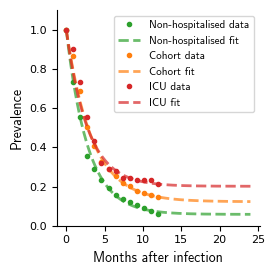

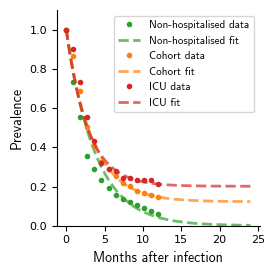

In [77]:
# visualise result
t_max = 24
t_steps = 1000
time = np.linspace(0, t_max, t_steps)

prevalence_func = lambda t,tau, p_AD: p_AD + (1-p_AD)*np.exp(-t/tau)

for scenario,(fig,ax) in zip(('AD','no_AD'),(plt.subplots(figsize=(3,3)),plt.subplots(figsize=(3,3)))):
    for hospitalisation in hospitalisation_groups:
        x = prevalence_data_per_hospitalisation_group.loc[hospitalisation].index.values
        y = prevalence_data_per_hospitalisation_group.loc[hospitalisation].values.squeeze()
        ax.plot(x,y,color=palette_colors[color_dict[hospitalisation]],marker='o',linestyle='None',label=f'{hospitalisation} data',markersize=3)

        if hospitalisation =='Non-hospitalised' and scenario == 'no_AD':
            tau = taus['Non-hospitalised (no AD)']
            p_AD = p_ADs['Non-hospitalised (no AD)']
        else:
            tau = taus[hospitalisation]
            p_AD = p_ADs[hospitalisation]
        ax.plot(time,prevalence_func(time,tau,p_AD),color=palette_colors[color_dict[hospitalisation]],linestyle='--',alpha=0.7, linewidth=2,
            label=f'{hospitalisation} fit')
    
    ax.set_xlabel('Months after infection',font=label_font)
    ax.set_ylabel('Prevalence',font=label_font)
    ax.set_ylim([0, 1.1])
    ax.legend(prop=legend_font)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(os.path.join(abs_dir,fig_result_folder,f'prevalence_first_fit_{scenario}'),dpi=600,bbox_inches='tight')


## MCMC

In [8]:
# objective functions for MCMC
def WSSE(theta,x,y):
    tau,p_AD = theta
    y_model = p_AD + (1-p_AD)*np.exp(-x/tau)
    SSE = sum((y_model-y)**2)
    WSSE = sum((1/y)**2 * (y_model-y)**2)
    return WSSE

def log_likelihood(theta, tau, x, y):
    p_AD = theta[0]
    y_model = p_AD + (1-p_AD)*np.exp(-x/tau)
    SSE = sum((y_model-y)**2)
    WSSE = sum((1/y)**2 * (y_model-y)**2)
    return -WSSE

def log_prior(theta,p_AD_bounds):
    p_AD = theta[0]
    if p_AD_bounds[0] < p_AD < p_AD_bounds[1]:
        return 0.0
    else:
        return -np.inf

def log_probability(theta, tau, x, y, bounds):
    lp = log_prior(theta,bounds)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta,tau, x, y)
    if np.isnan(ll):
        return -np.inf
    return lp + ll

# run MCMC
samplers = {}
p_AD_summary = pd.DataFrame(index=hospitalisation_groups,columns=['mean','sd','lower','upper'],dtype='float64')

for hospitalisation in hospitalisation_groups:
    
    x = prevalence_data_per_hospitalisation_group.loc[hospitalisation].index.values
    y = prevalence_data_per_hospitalisation_group.loc[hospitalisation].values.squeeze()

    tau = taus[hospitalisation]
    p_AD = p_ADs[hospitalisation]
    
    nwalkers = 32
    ndim = 1
    pos = p_AD + p_AD*1e-1 * np.random.randn(nwalkers, ndim)

    bounds = (0,1)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(tau,x,y,bounds)
    )
    samplers.update({hospitalisation:sampler})
    sampler.run_mcmc(pos, 20000, progress=True)

    flat_samples = sampler.get_chain(discard=1000, thin=30, flat=True)
    p_AD_summary['mean'][hospitalisation] = np.mean(flat_samples,axis=0)
    p_AD_summary['sd'][hospitalisation] = np.std(flat_samples,axis=0)
    p_AD_summary['lower'][hospitalisation] = np.quantile(flat_samples,0.025,axis=0)
    p_AD_summary['upper'][hospitalisation] = np.quantile(flat_samples,0.975,axis=0)

100%|██████████| 20000/20000 [00:49<00:00, 408.13it/s]


C:\Users\wolfd\AppData\Local\Temp\ipykernel_9492\227739027.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


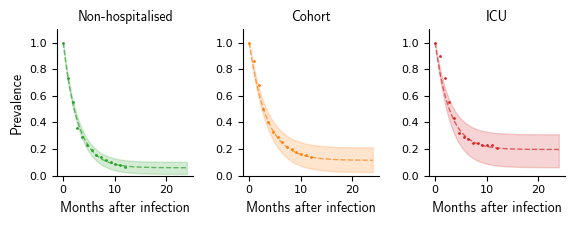

In [52]:
# visualise MCMC results
fig,axs = plt.subplots(1,3,figsize=(6,2.5))
axs=axs.reshape(-1)
for ax,hospitalisation in zip(axs,hospitalisation_groups):
    x = prevalence_data_per_hospitalisation_group.loc[hospitalisation].index.values
    y = prevalence_data_per_hospitalisation_group.loc[hospitalisation].values.squeeze()
    ax.plot(x,y,color=palette_colors[color_dict[hospitalisation]],marker='o',linestyle='None',label=f'{hospitalisation} data',markersize=1)
    
    tau = taus[hospitalisation]
    prevalences = []
    for n in range(200):
        prevalences.append(prevalence_func(time,tau,np.random.normal(p_AD_summary.loc[hospitalisation]['mean'],
                                                p_AD_summary.loc[hospitalisation]['sd'])))
    mean = np.mean(prevalences,axis=0)
    lower = np.quantile(prevalences,0.025,axis=0)
    upper = np.quantile(prevalences,0.975,axis=0)

    ax.plot(time,mean,color=palette_colors[color_dict[hospitalisation]],linestyle='--',alpha=0.7,linewidth=1)
    ax.fill_between(time,lower, upper,alpha=0.2, color=palette_colors[color_dict[hospitalisation]])
    ax.grid(False)
    ax.set_title(hospitalisation,font=label_font)
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('Months after infection',font=label_font)
axs[0].set_ylabel('Prevalence',font=label_font)

fig.tight_layout()
fig.savefig(os.path.join(abs_dir,fig_result_folder,f'prevalence_MCMC_fit.png'),dpi=600,bbox_inches='tight')

# QoL

In [53]:
QoL_Belgium_func = Life_table.QoL_Belgium_func

C:\Users\wolfd\AppData\Local\Temp\ipykernel_9492\4223220233.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


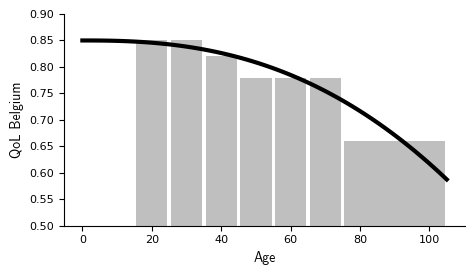

In [59]:
# visualise fit
fig,ax = plt.subplots(figsize=(5,3))
for index in QoL_Belgium.index:
    left = index.left
    right = index.right
    w = right-left
    ax.bar(left+w/2,QoL_Belgium[index],w-1,color='grey',alpha=0.5,label='data')
ax.plot(QoL_Belgium_func(LE_table.index.values),label='fit',color='black')
ax.set_xlabel('Age',font=label_font)
ax.set_ylabel('QoL Belgium',font=label_font)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([0.5, 0.9])
ax.grid(False)
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(abs_dir,fig_result_folder,'QoL_Belgium_fit.png'),dpi=600,bbox_inches='tight')

# Average QALY loss

In [55]:
prevalence_func = lambda t,tau, p_AD: p_AD + (1-p_AD)*np.exp(-t/tau)

# QALY loss func for fixed QoL after but beta is absolute difference and changing over time due to decreasing QoL reference
def QALY_loss_func(t,tau,p_AD,age,QoL_after):
    beta = QoL_Belgium_func(age+t/12)-QoL_after
    return prevalence_func(t,tau,p_AD) * max(0,beta)

draws = 200

# Pre-allocate new multi index series with index=hospitalisation,age,draw
multi_index = pd.MultiIndex.from_product([hospitalisation_groups+['Non-hospitalised (no AD)'],np.arange(draws),LE_table.index.values],names=['hospitalisation','draw','age'])
average_QALY_losses_per_age = pd.Series(index = multi_index, dtype=float)

# Calculate average QALY loss for each age 'draws' times
for idx,(hospitalisation,draw,age) in enumerate(tqdm(multi_index)):
    LE = LE_table[age]*12

    # use the same samples for beta and p_AD to calculate average QALY loss for each age
    if age==0:
        if hospitalisation == 'Non-hospitalised (no AD)':
            p_AD = 0
            beta = np.random.normal(QoL_difference_data.loc['Non-hospitalised']['mean'],
                                QoL_difference_data.loc['Non-hospitalised']['sd'])
        else:
            p_AD = np.random.normal(p_AD_summary.loc[hospitalisation]['mean'],
                                    p_AD_summary.loc[hospitalisation]['sd'])
            beta = np.random.normal(QoL_difference_data.loc[hospitalisation]['mean'],
                                    QoL_difference_data.loc[hospitalisation]['sd'])
            
        tau = taus[hospitalisation]

    # calculate the fixed QoL after getting infected for each age
    QoL_after = QoL_Belgium_func(age)-beta
    # integrate QALY_loss_func from 0 to LE  
    QALY_loss = quad(QALY_loss_func,0,LE,args=(tau,p_AD,age,QoL_after))[0]/12 
    average_QALY_losses_per_age[idx] = QALY_loss

100%|██████████| 84800/84800 [02:17<00:00, 617.30it/s] 


In [56]:
# bin data
average_QALY_losses_per_age_group = bin_data(average_QALY_losses_per_age)

In [57]:
# save result to dataframe
def get_lower(x):
    return np.quantile(x,0.025)
def get_upper(x):
    return np.quantile(x,0.975)
def get_sd(x):
    return np.std(x)

# average QALY per age
multi_index = pd.MultiIndex.from_product([hospitalisation_groups+['Non-hospitalised (no AD)'],LE_table.index.values],names=['hospitalisation','age'])
average_QALY_losses_per_age_summary = pd.DataFrame(index = multi_index, columns=['mean','sd','lower','upper'], dtype=float)

for hospitalisation in hospitalisation_groups+['Non-hospitalised (no AD)']:
    average_QALY_losses_per_age_summary['mean'][hospitalisation] = average_QALY_losses_per_age[hospitalisation].groupby(['age']).mean()
    average_QALY_losses_per_age_summary['sd'][hospitalisation] = average_QALY_losses_per_age[hospitalisation].groupby(['age']).apply(get_sd)
    average_QALY_losses_per_age_summary['lower'][hospitalisation] = average_QALY_losses_per_age[hospitalisation].groupby(['age']).apply(get_lower)
    average_QALY_losses_per_age_summary['upper'][hospitalisation] = average_QALY_losses_per_age[hospitalisation].groupby(['age']).apply(get_upper)

average_QALY_losses_per_age_summary.to_csv(os.path.join(abs_dir,data_result_folder,'average_QALY_losses_per_age.csv'))

# average QALY per age group
multi_index = pd.MultiIndex.from_product([hospitalisation_groups+['Non-hospitalised (no AD)'],average_QALY_losses_per_age_group.index.get_level_values('age_group').unique()],names=['hospitalisation','age_group'])
average_QALY_losses_per_age_group_summary = pd.DataFrame(index = multi_index, columns=['mean','sd','lower','upper'], dtype=float)

for hospitalisation in hospitalisation_groups+['Non-hospitalised (no AD)']:
    average_QALY_losses_per_age_group_summary['mean'][hospitalisation] = average_QALY_losses_per_age_group[hospitalisation].groupby(['age_group']).mean()
    average_QALY_losses_per_age_group_summary['sd'][hospitalisation] = average_QALY_losses_per_age_group[hospitalisation].groupby(['age_group']).apply(get_sd)
    average_QALY_losses_per_age_group_summary['lower'][hospitalisation] = average_QALY_losses_per_age_group[hospitalisation].groupby(['age_group']).apply(get_lower)
    average_QALY_losses_per_age_group_summary['upper'][hospitalisation] = average_QALY_losses_per_age_group[hospitalisation].groupby(['age_group']).apply(get_upper)

average_QALY_losses_per_age_group_summary.to_csv(os.path.join(abs_dir,data_result_folder,'average_QALY_losses_per_age_group.csv'))

C:\Users\wolfd\AppData\Local\Temp\ipykernel_9492\644371021.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


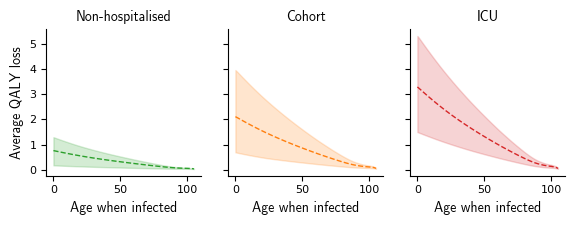

In [75]:
# Visualise results
fig,axs = plt.subplots(1,3,figsize=(6,2.5),sharey=True,sharex=True)
for ax,hospitalisation in zip(axs,hospitalisation_groups):
    mean = average_QALY_losses_per_age_summary.loc[hospitalisation]['mean']
    lower = average_QALY_losses_per_age_summary.loc[hospitalisation]['lower']
    upper = average_QALY_losses_per_age_summary.loc[hospitalisation]['upper']
    ax.plot(LE_table.index.values,mean,color=palette_colors[color_dict[hospitalisation]],linestyle='--',label=f'{hospitalisation}',linewidth=1)
    ax.fill_between(LE_table.index.values,lower,upper,alpha=0.20, color=palette_colors[color_dict[hospitalisation]])
    
    ax.grid(False)
    ax.set_xlabel('Age when infected',font=label_font)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_title(hospitalisation,font=label_font)

axs[0].set_ylabel('Average QALY loss',font=label_font)
fig.tight_layout()
fig.savefig(os.path.join(abs_dir,fig_result_folder,f'average_QALY_losses_per_age.png'),dpi=600,bbox_inches='tight')

# QALY deaths

In [4]:
Life_table.compute_QALY_D_x(r=0)

age
0      66.254872
1      65.614116
2      64.777931
3      63.933929
4      63.090718
         ...    
101     1.165820
102     1.058695
103     0.876331
104     0.628946
105     0.292906
Length: 106, dtype: float64

In [5]:
Life_table.compute_QALY_D_x(r=0.03)

age
0      25.635852
1      25.561337
2      25.466790
3      25.368706
4      25.267805
         ...    
101     1.133387
102     1.031655
103     0.857581
104     0.619162
105     0.290754
Length: 106, dtype: float64

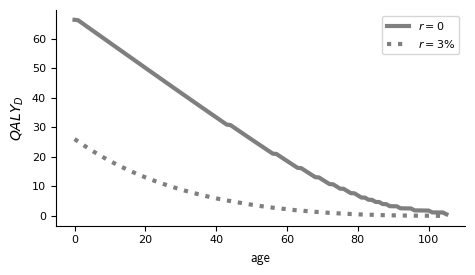

In [5]:
# QALY losses due COVID death
fig,ax = plt.subplots(figsize=(5,3))
QALY_D_per_age = Life_table.compute_QALY_D_x(r=0)
ax.plot(QALY_D_per_age,color=palette_colors['black'],label=r'$r=0$')
QALY_D_per_age = Life_table.compute_QALY_D_x(r=0.03)
ax.plot(QALY_D_per_age,color=palette_colors['black'],linestyle=':',label=r'$r=3\%$')
ax.grid(False)
ax.set_xlabel('age',font=label_font)
ax.set_ylabel(r'$QALY_D$',font=label_font)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(prop=legend_font)
fig.tight_layout()
fig.savefig(os.path.join(abs_dir,fig_result_folder,'QALY_D.png'),dpi=600,bbox_inches='tight')